In [1328]:
import numpy as np
import matplotlib.pyplot as plt

##### Set up classes

In [1329]:
class particle:
     def __init__(self, alive, mu, x, g, w):
        self.alive = alive
        self.mu = mu
        self.x = x
        self.g = g
        self.w = w

In [1330]:
class tally:
    def __init__(self, flux, current):
        self.flux = flux
        self.current = current
        self.flux_sdev = np.zeros_like(flux)
        self.current_sdev = np.zeros_like(current)

In [1331]:
class material:
    def __init__(self, nuSigmaF, SigmaS, SigmaT):
        self.nuSigmaF = nuSigmaF
        self.SigmaS = SigmaS
        self.SigmaT = SigmaT

In [1332]:
class cell:
    def __init__(self, left, right, material):
        self.left = left
        self.right = right
        self.material = material

In [1333]:
class mesh:
    def __init__(self, Nx, L, bc):
        self.Nx = Nx
        self.L = L
        self.dx = L/(Nx-1)
        self.mesh_x = np.linspace(0, L, Nx)
        self.mesh_flux = np.linspace(0, L, Nx-1)
        self.bc = bc

##### Set up functions

In [1334]:
def pushn_P(p):
    PUSH = 1e-5 
    if p.mu > 0:
        p.x += PUSH
    else:
        p.x += -PUSH

In [1335]:
def calculate_fission_source():
    # get values
    flux = tally1.flux
    source = np.zeros(mesh1.Nx-1)
    dx = mesh1.dx
    index = 0
    
    # loop through all cells
    for i in range(len(cells)):
        # get cell and material data
        left = cells[i].left
        right = cells[i].right
        material = cells[i].material
        nuSigmaF = material.nuSigmaF
        bins = int((right - left) / dx)
        
        # calculate source for current cell
        for j in range(bins):
            j += index
            source[j] = nuSigmaF[0]*flux[j,0] + nuSigmaF[1]*flux[j,1]
            
        index = j+1
        
    return source

In [1336]:
def zero_tally(tally):
    tally.flux = np.zeros_like(tally.flux)
    tally.current = np.zeros_like(tally.current)
    tally.flux_sdev = np.zeros_like(tally.flux_sdev)
    tally.current_sdev = np.zeros_like(tally.current_sdev)

In [1337]:
def calculate_k(fission_source, k):
    dx = mesh1.dx
    k_new = k * np.sum(dx*fission_source)
    return k_new

In [1338]:
def check_collision(p, material):
    eta = np.random.random()
    SigmaT = material.SigmaT[p.g]
    SigmaS = np.sum(material.SigmaS[p.g,:])
    
    if eta < SigmaS / SigmaT:
        return "scatter"
    else:
        return "absorb"

In [1339]:
def move_particle(p, x):
    if p.mu > 0:
        p.x += x * abs(p.mu)
    else:
        p.x -= x * abs(p.mu)

In [1340]:
def get_surface(p, bin_id):
    if p.mu > 0:
        return bin_id+1
    else:
        return bin_id

In [1341]:
def get_material(p, cells):
    for i in range(len(cells)):
        right = cells[i].right
        left = cells[i].left
        if p.x >= left and p.x < right:
            return cells[i].material

In [1342]:
def isotropic_scatter(p):
    p.mu = 2 * np.random.random() - 1

In [1343]:
def energy_scatter(material, p):
    SigmaS = material.SigmaS[p.g,:].copy()

    # normalize SigmaS
    SigmaS *= 1/np.sum(SigmaS)

    # sample energy group
    eta = np.random.random()
    if eta < SigmaS[0]:
        p.g = 0
    else:
        p.g = 1        

In [1344]:
def sample_location(p, source):
    sample = source.copy()
    eta = np.random.random()
    
    for i in range(len(sample)):
        if eta > sample[i]:
            sample[i+1] += sample[i]
            continue
        else:
            bin_id = i
            break
            
    eta = np.random.random()
    p.x = bin_id*mesh1.dx + eta*mesh1.dx

In [1345]:
def closeout_tally(tally, N_histories):
    tally.flux *= 1/N_histories
    tally.current *= 1/N_histories
    flux = tally.flux.copy()
    current = tally.current.copy()
    tally.flux_sdev = np.sqrt(
        (tally.flux_sdev / N_histories - np.square(flux)) / (N_histories - 1)
    )
    tally.current_sdev = np.sqrt(
        (tally.current_sdev / N_histories - np.square(current)) / (N_histories - 1)
    )

##### Main loops

In [1346]:
def loop_source(N_histories, source, k_old):
    for i in range(N_histories):
        # create particle with x, mu, g, w
        p = particle(True, 0, 0, 0, 0)
        
        sample_location(p, source)
        isotropic_scatter(p)
        p.g = 0
        p.w = 1/k_old
        
        while p.alive:

            # get particle bin
            bin_id = np.searchsorted(mesh1.mesh_x, p.x) - 1
            
            # get material
            material = get_material(p, cells)
            
            # sample distance to collision
            distance_to_collision = -np.log(np.random.random())/material.SigmaT[p.g]
            
            # calculate distance to surface
            if p.mu < 0:
                distance_to_surface = abs((p.x - (bin_id * mesh1.dx)) / p.mu)
            elif p.mu > 0:
                distance_to_surface = (((bin_id+1) * mesh1.dx) - p.x) / p.mu
            # surface crossing
            if distance_to_collision >= distance_to_surface:
                # get surface
                surface = get_surface(p, bin_id)
                
                # score flux in bin
                score_flux = distance_to_surface * p.w
                tally1.flux[bin_id, p.g] += score_flux
                tally1.flux_sdev[bin_id, p.g] += np.square(score_flux)
                
                # score current on surface
                score_current = p.w
                tally1.current[surface, p.g] += score_current
                tally1.current_sdev[surface, p.g] += np.square(score_current)
                
                # move particle to surface 
                move_particle(p, distance_to_surface)
                
                # check bcs
                if surface == 0 or surface == mesh1.Nx-1:
                    if mesh1.bc == "vacuum":
                        p.alive = False
                    elif mesh1.bc == "reflective":
                        p.mu *= -1
                        
                # push into next bin
                pushn_P(p)
                    
            else:
                # score tally
                score_flux = distance_to_collision * p.w
                tally1.flux[bin_id, p.g] += score_flux
                tally1.flux_sdev[bin_id, p.g] += np.square(score_flux)
                
                # move particle to collision
                move_particle(p, distance_to_collision)

                # get collision
                collision = check_collision(p, material)
                if collision == "absorb": # kill particle
                    p.alive = False
                elif collision == "scatter": # tally scatter, sample new direction, change energy
                    isotropic_scatter(p)
                    energy_scatter(material, p)
                else:
                    print("No collision")
            

    # close tally
    closeout_tally(tally1, N_histories)

In [1347]:
def loop_main(N_cycles, inactive_cycles, N_histories):
    cycle = 0
    simulation_end = False

    # build initial source
    fission_source = np.ones(mesh1.Nx-1)
    k_total = 0
    k_old = 1
    
    while not simulation_end:
        print(cycle)
        
        # zero out tally
        zero_tally(tally1)
        
        # normalize fission source
        fission_source *= 1/np.sum(fission_source)
        
        # run particles
        loop_source(N_histories, fission_source, k_old)
        
        # check iteration
        cycle += 1
        if cycle == N_cycles:
            simulation_end = True
        elif cycle < inactive_cycles:
            fission_source = calculate_fission_source()
        else:
            fission_source = calculate_fission_source()
            k_new = calculate_k(fission_source, k_old)
            k_old = k_new
            k_total += k_new

    keff = k_total/(N_cycles-inactive_cycles)
    print(keff)

##### Test Problem

#### Test A

In [1348]:
# materials
mox = material(np.array([0,1.05]), 
              np.array([[0.25,0],[0,0]]), 
              np.array([0.25,0.75]))

u = material(np.array([0,0.40]), 
              np.array([[0.25,0],[0,0]]), 
              np.array([0.25,0.25]))

water = material(np.array([0,0]), 
              np.array([[0.20,0.05],[0,1.25]]), 
              np.array([0.25,1.25]))
# cells
cells = []

for i in range(8):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, mox), cell(i+.9375, i+1.25, water)])

for i in range(8, 16):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, u), cell(i+.9375, i+1.25, water)])

# mesh
mesh1 = mesh(128 + 1, 20, "reflective")

# tally
tally1 = tally(np.zeros((mesh1.Nx-1, 2)), 
               np.zeros((mesh1.Nx, 2)))

In [1349]:
N_cycles = 100
inactive_cycles = 25
N_histories = 1000

loop_main(N_cycles, inactive_cycles, N_histories)

0


<ipython-input-1345-151ff06c66d5>:9: RuntimeWarning: invalid value encountered in sqrt
  tally.current_sdev = np.sqrt(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.23269601362488623


c. i.

In [1352]:
# get values
flux = tally1.flux
dx = mesh1.dx
hist = np.zeros([48,2])
index = 0

# loop through all cells
for i in range(len(cells)):
    # get cell and material data
    average0 = 0
    average1 = 0
    
    left = cells[i].left
    right = cells[i].right
    material = cells[i].material
    nuSigmaF = material.nuSigmaF
    bins = int((right - left) / dx)

    # calculate source for current cell
    for j in range(bins):
        j += index
        average0 += flux[j,0]
        average1 += flux[j,1]
        
    hist[i,0] = average0 / bins
    hist[i,1] = average1 / bins

    index = j+1

In [1353]:
histo = hist.copy()
avg = np.zeros([16,2])
for i in range(16):
    j = i*3
    avg[i,:] += (histo[j,:] + histo[j+1,:] + histo[j+2,:]) / 3

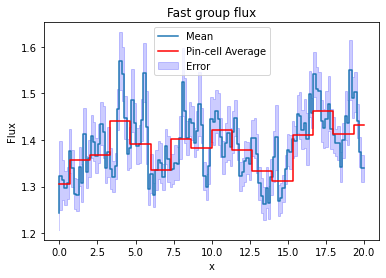

In [1288]:
mid_0 = tally1.flux[:,0]
sd_0 = tally1.flux_sdev[:,0]

plt.step(mesh1.mesh_flux, mid_0, label="Mean")
plt.fill_between(mesh1.mesh_flux, mid_0-sd_0, mid_0+sd_0,step="pre", alpha=.2, color="b", label="Error")
plt.step(np.linspace(0,20,16), avg[:,0], color="r", where='mid', label="Pin-cell Average")
plt.legend()
plt.title("Fast group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

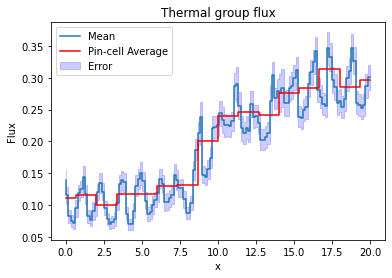

In [1289]:
mid_0 = tally1.flux[:,1]
sd_0 = tally1.flux_sdev[:,1]

plt.step(mesh1.mesh_flux, mid_0, label="Mean")
plt.fill_between(mesh1.mesh_flux, mid_0-sd_0, mid_0+sd_0,step="pre", alpha=.2, color="b", label="Error")
plt.step(np.linspace(0,20,16), avg[:,1], color="r", where='mid', label="Pin-cell Average")
plt.legend()
plt.title("Thermal group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

c. ii.

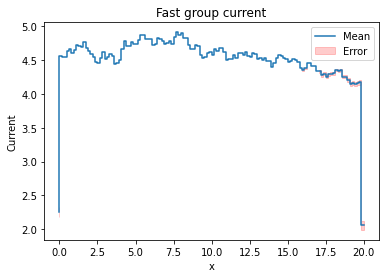

In [1194]:
mid_0 = tally1.current[:,0]
sd_0 = tally1.current_sdev[:,0]

plt.step(mesh1.mesh_x, mid_0, label="Mean")
plt.fill_between(mesh1.mesh_x, mid_0-sd_0, mid_0+sd_0,step="pre", alpha=.2, color="r", label="Error")
plt.legend()
plt.title("Fast group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()

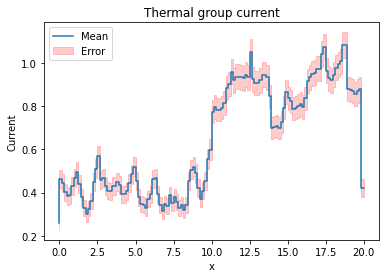

In [1193]:
mid_1 = tally1.current[:,1]
sd_1 = tally1.current_sdev[:,1]

plt.step(mesh1.mesh_x, mid_1, label="Mean")
plt.fill_between(mesh1.mesh_x, mid_1-sd_1, mid_1+sd_1,step="pre", alpha=.2, color="r", label="Error")
plt.legend()
plt.title("Thermal group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()

#### Test B

In [1310]:
# materials

mox = material(np.array([0,0.75]), 
              np.array([[0.21,0.04],[0,1.0]]), 
              np.array([0.25,1.25]))

u = material(np.array([0,0.25]), 
              np.array([[0.21,0.04],[0,0.9]]), 
              np.array([0.25,1.1]))

water = material(np.array([0,0]), 
              np.array([[0.17,0.06],[0,1.1]]), 
              np.array([0.25,1.1]))
# cells
cells = []

for i in range(8):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, mox), cell(i+.9375, i+1.25, water)])

for i in range(8, 16):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, u), cell(i+.9375, i+1.25, water)])

# mesh
mesh1 = mesh(128 + 1, 20, "reflective")

# tally
tally1 = tally(np.zeros((mesh1.Nx-1, 2)), 
               np.zeros((mesh1.Nx, 2)))

In [1311]:
N_cycles = 100
inactive_cycles = 25
N_histories = 1000

loop_main(N_cycles, inactive_cycles, N_histories)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.32742212927977055


c. i.

In [1312]:
# get values
flux = tally1.flux
dx = mesh1.dx
hist = np.zeros([48,2])
index = 0

# loop through all cells
for i in range(len(cells)):
    # get cell and material data
    average0 = 0
    average1 = 0
    
    left = cells[i].left
    right = cells[i].right
    material = cells[i].material
    nuSigmaF = material.nuSigmaF
    bins = int((right - left) / dx)

    # calculate source for current cell
    for j in range(bins):
        j += index
        average0 += flux[j,0]
        average1 += flux[j,1]
        
    hist[i,0] = average0 / bins
    hist[i,1] = average1 / bins

    index = j+1

In [1313]:
histo = hist.copy()
avg = np.zeros([16,2])
for i in range(16):
    j = i*3
    avg[i,:] += (histo[j,:] + histo[j+1,:] + histo[j+2,:]) / 3

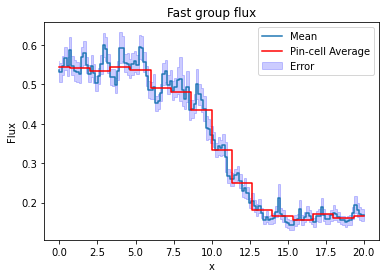

In [1314]:
mid_0 = tally1.flux[:,0]
sd_0 = tally1.flux_sdev[:,0]

plt.step(mesh1.mesh_flux, mid_0, where='pre',label="Mean")
plt.fill_between(mesh1.mesh_flux, mid_0-sd_0, mid_0+sd_0, step="pre", alpha=.2, color="b", label="Error")
plt.step(np.linspace(0,20,16), avg[:,0], color="r", where='mid',label="Pin-cell Average")
plt.legend()
plt.title("Fast group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

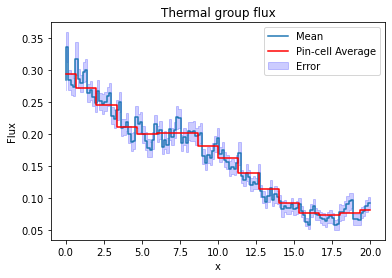

In [1315]:
mid_0 = tally1.flux[:,1]
sd_0 = tally1.flux_sdev[:,1]

plt.step(mesh1.mesh_flux, mid_0, label="Mean")
plt.fill_between(mesh1.mesh_flux, mid_0-sd_0, mid_0+sd_0,step="pre", alpha=.2, color="b", label="Error")
plt.step(np.linspace(0,20,16), avg[:,1], color="r", where='mid', label="Pin-cell Average")
plt.legend()
plt.title("Thermal group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

c. ii.

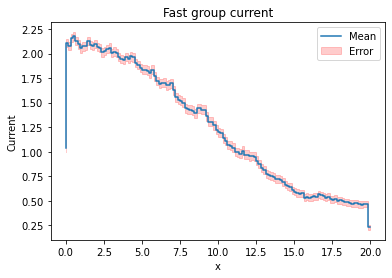

In [1246]:
mid_0 = tally1.current[:,0]
sd_0 = tally1.current_sdev[:,0]

plt.step(mesh1.mesh_x, mid_0, label="Mean")
plt.fill_between(mesh1.mesh_x, mid_0-sd_0, mid_0+sd_0,step="pre", alpha=.2, color="r", label="Error")
plt.legend()
plt.title("Fast group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()

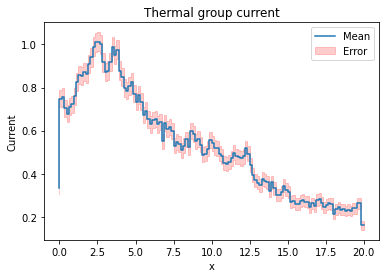

In [1244]:
mid_1 = tally1.current[:,1]
sd_1 = tally1.current_sdev[:,1]

plt.step(mesh1.mesh_x, mid_1, label="Mean")
plt.fill_between(mesh1.mesh_x, mid_1-sd_1, mid_1+sd_1,step="pre", alpha=.2, color="r", label="Error")
plt.legend()
plt.title("Thermal group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()